In [2]:
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import ffmpeg
from tensorflow import keras
from tensorflow.keras import layers
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow.keras as keras
import librosa.display
import tensorflow.math as math
import sklearn
import copy

**Loading the audio data**

In [3]:
# load audio signals

path = "./DATA SIGNALS"
files = os.listdir(path)
files.sort()

data = []

for i in range(len(files)):
    if files[i][-4:] != ".wav": # this line ensures that only .wav files are added to "data"
        continue
    filename, sr = librosa.load(os.path.join(path, files[i]))
    data.append(filename)

data = np.array(data, dtype=object)

# this data has shape (88,), so 88 objects
# the folder has one hidden file, .DS_Store, which was not appended to the data

**Zero-padding the signals to make all durations equal**

This code should **not** be uncommented. This code was used on a previous folder with data which had sound files with different durations. The folder that was loaded above already has the new, zero-padded sound files and should not be edited further.

In [3]:
# this code calculates the duration of samples and then zero-pads them so that they are all 4 seconds long
"""
from pydub import AudioSegment
import ffprobe

def get_duration(idx, origin):
    sr = 22050
    sample_duration = 1/sr
    duration = sample_duration * len(origin[idx])
    return duration # in seconds

max_duration = 4 # this is in seconds

for i in range(len(filescopy)):
    padding = (max_duration - get_duration(i, datacopy)) * 1000 # has to be in ms
    audio = AudioSegment.from_wav(os.path.join(path, filescopy[i]))
    silence = AudioSegment.silent(duration=padding)
    padded = audio + silence
    
    padded.export(filescopy[i], format="wav")

"""  

'\nfrom pydub import AudioSegment\nimport ffprobe\n\ndef get_duration(idx, origin):\n    sr = 22050\n    sample_duration = 1/sr\n    duration = sample_duration * len(origin[idx])\n    return duration # in seconds\n\nmax_duration = 4 # this is in seconds\n\nfor i in range(len(filescopy)):\n    padding = (max_duration - get_duration(i, datacopy)) * 1000 # has to be in ms\n    audio = AudioSegment.from_wav(os.path.join(path, filescopy[i]))\n    silence = AudioSegment.silent(duration=padding)\n    padded = audio + silence\n    \n    padded.export(filescopy[i], format="wav")\n\n'

**Loading the target data in the raw text file**

In [4]:
with open("P-centers.txt", "r") as f:
    contents = f.read()
    
    p_centers_list = contents.split("\n") # each line in the text file has been added as an item to p_centers_list


**Transforming the text file data into np array target data**

In [5]:
# this function makes the timestamp strings into floats of just the numbers
# it will be used to strip the p-center timestamps from unnecessary characters like p-center index etc
# for example, the string "1: 0.09945641792483517 seconds" becomes the float 0.09945641792483517
def item_strip(string):
    started = False
    newstring = ""
    
    for i in range(len(string)):
        if string[i] == " " and started == False:
            started = True
            continue
            
        if string[i] == " " and started == True:
            started == False
            break
            
        if started == True:
            newstring += string[i]
            continue
            
        else:
            continue
    
    
    return float(newstring)

In [6]:
# in this function, the list is made into a dictionary
# each key-value pair is: key=str(name of .wav file), value=list(all float(timestamps) for that file)
# the timestamps are floats in seconds

def make_dict(p_centers_list):
    p_centers_dict = {}
 
    
    value_collection = False # when the program recognizes an item to be a timestamp, this becomes True
    newkey = ""
    newvaluelist = []

    for i in range(len(p_centers_list)):
        item = p_centers_list[i] # loops through every item in the list
        # item can either be sound file name or p-center timestamp

        while value_collection == True: # for the first item in the list, this is False
            if item[0] == "n" or item[0] == "p" or item[0] == "z": # this is the case if item = name of .wav file
                value_collection = False
                p_centers_dict[newkey[:-1]+".wav"] = newvaluelist # the key-value pair is added to the dict
                newvaluelist = [] # the list with timestamps is emptied again
                continue
            elif item == p_centers_list[-1]: # if the item is the last timestamp in the list
                newvaluelist.append(item_strip(item))
                p_centers_dict[newkey[:-1]+".wav"] = newvaluelist # key-value  pair is added to dict
                break
            else:
                newvaluelist.append(item_strip(item)) # adds timestamp to list with timestamps, this later becomes value in dictionary
                break

        if item[0] == "n" or item[0] == "p" or item[0] == "z": # if item is a name
            newkey = item
            value_collection = True
            continue
            
        
    return p_centers_dict


p_centers_dict = make_dict(p_centers_list)     
        


Now, the dictionary is transformed into a numpy array with the length of the frame number of each sound file. The array consists of either the value 0 or 1, which means that there either is a p-center in that particular frame or there is not.

In [7]:
# definitions

sr = 22050 # this means 22050 samples per second
duration_of_signals = 3.9998 # average duration of signals
num_of_samples = sr * duration_of_signals # =88195.59; sampling rate * duration of signals
sample_duration = 1/sr # =0.00004535; how long 1 sample is
frame_length = 2048 # this tells us how many samples there are in each frame
hop_size = 512 # this decides how many frames there will be

In [8]:
# how to calculate the times of kth frame
# k = frame_idx
# 0 means no p-center in this frame, 1 means yes p-center in this frame

def start_of_frame(k):
    hop_size = 512
    sr = 22050
    return (k * hop_size) / sr

def end_of_frame(k):
    hop_size = 512
    sr = 22050
    frame_length = 2048
    return (k * hop_size + (frame_length-1)) / sr

def frame_center(k):
    start = start_of_frame(k)
    end = end_of_frame(k)
    return (start+end)/2


def pcs_in_frames(file_timelist):
    zeros = [0]
    frame_occurrences = zeros*169 # by default, all frames have 0
    
    for i in range(len(file_timelist)):
        pcs_in_frame = []
        pc = file_timelist[i]

        for k in range(169):
            start = start_of_frame(k)
            end = end_of_frame(k)
            if pc >= start and pc < end:
                pcs_in_frame.append(k) # list with items being the frame numbers k where pc occurs

        if len(pcs_in_frame) == 0:
            continue

        elif len(pcs_in_frame) == 1:
            frame_occurrences[pcs_in_frame[0]] = 1
            continue

        elif len(pcs_in_frame) > 1:
            center_list = []
            for q in range(len(pcs_in_frame)):
                # k = pc_in_frame[q]
                center = frame_center(pcs_in_frame[q])
                distance_from_center = abs(center-pc)
                center_list.append(distance_from_center) # all distances
            closest_frame = center_list.index(min(center_list)) # idx of frame with min distance
            # this is the same index this frame has in pc_in_frame
            frame_occurrences[pcs_in_frame[closest_frame]] = 1
            continue
    
    return frame_occurrences


In [9]:
# using the function pcs_in_frames for all p-centers in all sound files:

target_data = []

for name, timelist in p_centers_dict.items():
    frame_occurrences = pcs_in_frames(timelist)
    # add name and frame_occurrences to list
    target_data.append(frame_occurrences)
    
# transform list into numpy array
target_data = np.array(target_data)

**Extracting MFCCs**


In [10]:
# extracting mfccs
def get_mfccs(data, n_mfcc, sr):
    mfccs = []
    for i in range(len(data)): # loop through sound files
        signal_mfcc = librosa.feature.mfcc(data[i], n_mfcc=n_mfcc, sr=sr) # n_mfcc is number of mfccs
        signal_mfcc_t = signal_mfcc.T # transform matrix from (20, 169) to (169, 20)
        
        mfccs.append(signal_mfcc_t)
    
    return mfccs

In [11]:
mfccs = get_mfccs(data, 20, sr) # get 20 mfccs
mfccs = np.array(mfccs)

<ipython-input-10-4eb6820573f4>:5: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal_mfcc = librosa.feature.mfcc(data[i], n_mfcc=n_mfcc, sr=sr) # n_mfcc is number of mfccs
<ipython-input-10-4eb6820573f4>:5: FutureWarning: Pass y=[-0.00024276 -0.00041481 -0.00031452 ...  0.          0.
  0.        ] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal_mfcc = librosa.feature.mfcc(data[i], n_mfcc=n_mfcc, sr=sr) # n_mfcc is number of mfccs


In [12]:
# Data shapes
print(mfccs.shape)
print(target_data.shape)

(88, 169, 20)
(88, 169)


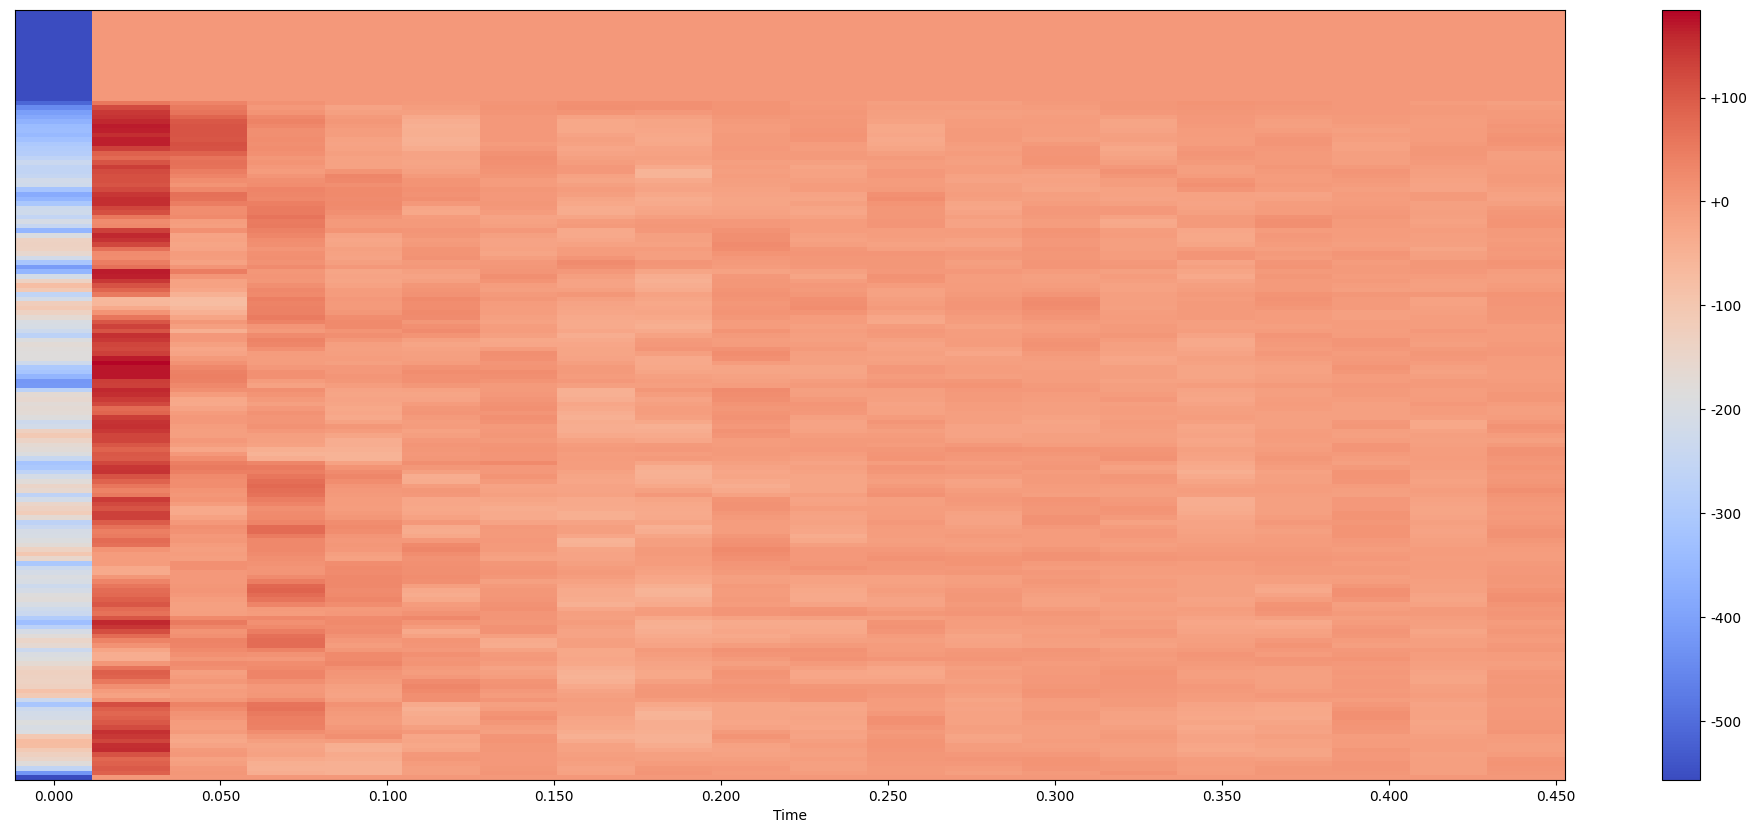

In [15]:
# visualising mfccs for one sample signal
sample_signal_mfccs = mfccs[10]

plt.figure(figsize=(25,10))
librosa.display.specshow(sample_signal_mfccs,
                        x_axis="time",
                        sr=sr)

plt.colorbar(format="%+2.f") # this color bar shows the coefficients
plt.show()

**Extract amplitude envelope**

In [16]:
# extracting amplitude envelope

def get_amplitude_envelope(data, frame_size, hop_length):
    amplitude_envelopes = []
    
    for i in range(len(data)):
        current_signal_ae = []
        # calculate AE for each frame in each signal in data
        signal = data[i]
        for i in range(0, len(signal), hop_length): # jumps from frame to frame
            current_frame_ae = max(signal[i:i+frame_size])
            current_signal_ae.append(current_frame_ae)
        
        amplitude_envelopes.append(current_signal_ae)
        
    return np.array(amplitude_envelopes)

In [17]:
amplitude_envelopes = get_amplitude_envelope(data, frame_length, hop_size)

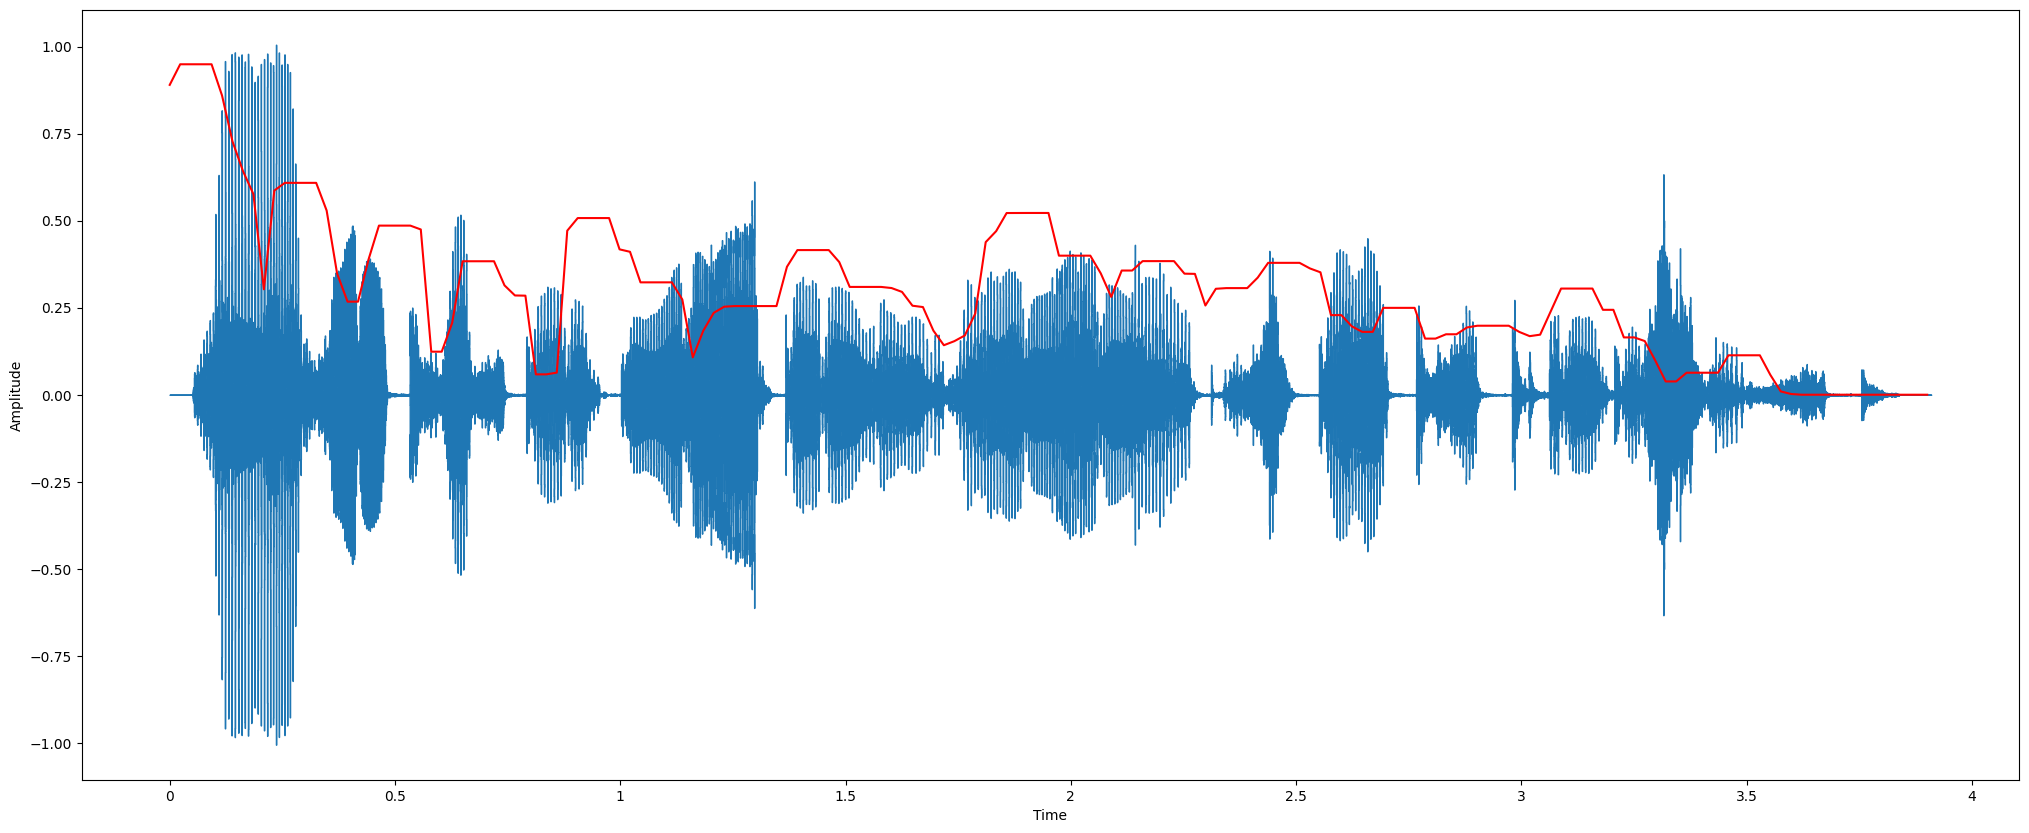

This graph shows the amplitude envelope for the audio signal n_01naofrr.wav


In [18]:
# visualise amplitude envelope for a sample audio signal

sample_signal = data[0]
sample_signal_aes = amplitude_envelopes[50]

plt.figure(figsize=(25,10))
librosa.display.waveshow(sample_signal)

# calculating time
frames = range(len(sample_signal_aes))
t = librosa.frames_to_time(frames, hop_length=hop_size)

plt.ylabel("Amplitude")
plt.plot(t, sample_signal_aes, color="r")

plt.show()


print("This graph shows the amplitude envelope for the audio signal", files[0])

**Extract root mean squared energy**

In [19]:
# extracting energy by computing root mean squared energy
def get_rmse(data, frame_length, hop_size):
    rmse = []
    
    for i in range(len(data)):
        signal = data[i]
        signal_rmse = librosa.feature.rms(signal, frame_length, hop_size)
        rmse.append(signal_rmse[0]) # we only want the first dimension because those are the rmse values
    
    return np.array(rmse)
    

In [20]:
rmse = get_rmse(data, frame_length, hop_size)

<ipython-input-19-3c1e1c828fb1>:7: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.], S=2048, frame_length=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal_rmse = librosa.feature.rms(signal, frame_length, hop_size)
<ipython-input-19-3c1e1c828fb1>:7: FutureWarning: Pass y=[-0.00024276 -0.00041481 -0.00031452 ...  0.          0.
  0.        ], S=2048, frame_length=512 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  signal_rmse = librosa.feature.rms(signal, frame_length, hop_size)


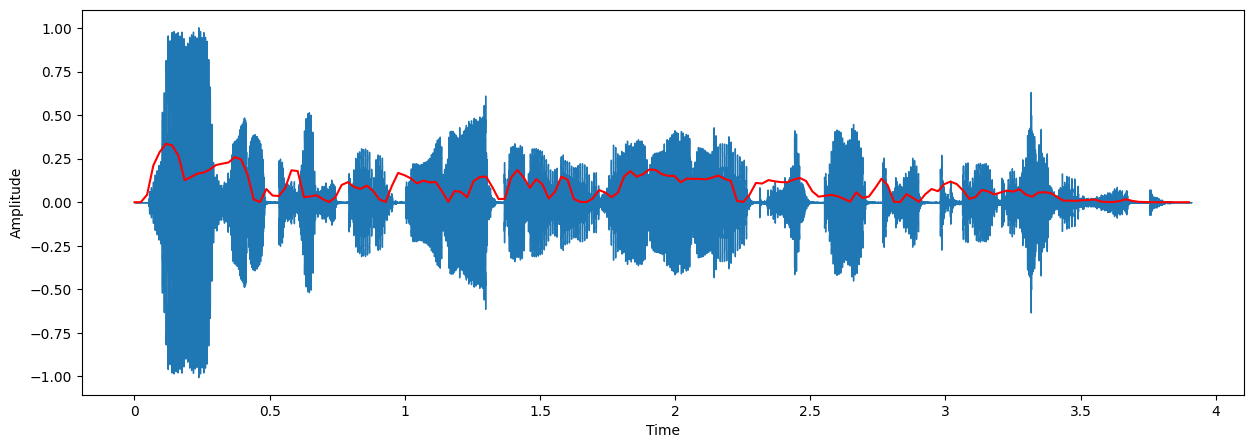

This graph shows the RMSE for the audio signal n_01naofrr.wav


In [21]:
# visualise rmse for a sample signal
sample_signal = data[0]
sample_signal_rmse = rmse[40]

plt.figure(figsize=(15,5))

librosa.display.waveshow(sample_signal)

# calculate time
frames = range(0, sample_signal_rmse.size)
t = librosa.frames_to_time(frames, hop_length=hop_size)


plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.plot(t, sample_signal_rmse, color="r")
plt.show()

print("This graph shows the RMSE for the audio signal", files[0])

**LSTM**

In [22]:
# test random numbers
# this generates data for the baseline model
from random import random
l1 = []
for i in range(88):
    l2 = []
    for j in range(169):
        num = random()
        l2.append(num)
    l1.append(l2)
    
testl = np.array(l1)
testl = testl.reshape((88, 169, 1))
print(testl.shape)
# for testing random numbers, this array "testl" can be used as input in the model

(88, 169, 1)


In [23]:
# this is the LSTM with mfccs as input

# define function to prepare data set
def prepare_dataset_RNN(test_size, val_size, X, y):
    
    # create the train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create the train/val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# define function to build model
def build_model_RNN(input_shape):
    
    # create model
    model = keras.Sequential()
    
    # masking layer
    model.add(keras.layers.Masking(mask_value=0, input_shape = input_shape))
    
    model.add(keras.layers.LSTM(128, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.LSTM(64, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation ='relu'))
    model.add(keras.layers.Dropout(0.1))
    
    
    # output layer with softmax activation
    model.add(keras.layers.Dense(2, activation = 'softmax'))
    
    return model 

# define data
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset_RNN(0.15, 0.15,mfccs, target_data)

# build the RNN
input_shape = (X_train.shape[1], X_train.shape[2]) #( 169, 20 )
model_rnn = build_model_RNN(input_shape)
print(input_shape)


# compile the network 
# temporal sample weighting is used, because we have input sequences
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay = 1e-4)
model_rnn.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics = ['accuracy'], sample_weight_mode = "temporal")

# determine sample_weights
# each samples weight is inversely proportional to how often it occurs in the data
# (i.e., 1s are weighted more heavily than 0s)
sample_weights = y_train.copy()
sample_weights = sample_weights.astype(float)
sample_weights[sample_weights == 0] = 1/(np.count_nonzero(y_train == 0)/np.prod(y_train.shape))
sample_weights[sample_weights == 1] = 1/(np.count_nonzero(y_train == 1)/np.prod(y_train.shape))

# train the RNN with sample weights
# hist_lstm is defined so that it can be used in the plot later on
hist_lstm = model_rnn.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size = 32,
          epochs = 30, sample_weight = sample_weights)

# generate predictions and a confusion matrix
y_pred = model_rnn.predict(X_test)
y_pred_cl = y_pred.argmax(axis=-1)
matrix = math.confusion_matrix(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))

# evaluate the RNN on the test set
# this calculates overall accuracy
test_error, test_accuracy = model_rnn.evaluate(X_test, y_test, verbose = 1)
print("accuracy on test set is: {}".format(test_accuracy))

# calculate balanced accuracy, which is probably a better evaluation metrics for this data set
bal_acc = sklearn.metrics.balanced_accuracy_score(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))
print("balanced accuracy on test set is: {}".format(bal_acc))


(169, 20)
Epoch 1/30
2/2 [==============================] - 9s 3s/step - loss: 1.5299 - accuracy: 0.6258 - val_loss: 0.7824 - val_accuracy: 0.1297
Epoch 2/30
2/2 [==============================] - 0s 205ms/step - loss: 1.3697 - accuracy: 0.4252 - val_loss: 0.6623 - val_accuracy: 0.7120
Epoch 3/30
2/2 [==============================] - 0s 200ms/step - loss: 1.3119 - accuracy: 0.5995 - val_loss: 0.5612 - val_accuracy: 0.8131
Epoch 4/30
2/2 [==============================] - 1s 367ms/step - loss: 1.2446 - accuracy: 0.6943 - val_loss: 0.5260 - val_accuracy: 0.7880
Epoch 5/30
2/2 [==============================] - 1s 435ms/step - loss: 1.1451 - accuracy: 0.7214 - val_loss: 0.5139 - val_accuracy: 0.7456
Epoch 6/30
2/2 [==============================] - 1s 436ms/step - loss: 1.0646 - accuracy: 0.7132 - val_loss: 0.3501 - val_accuracy: 0.8471
Epoch 7/30
2/2 [==============================] - 1s 379ms/step - loss: 1.1437 - accuracy: 0.7167 - val_loss: 0.6818 - val_accuracy: 0.6612
Epoch 8/30
2/

In [25]:
# this is the LSTM with amplitude_envelopes as input

# define function to prepare data set
def prepare_dataset_RNN(test_size, val_size, X, y):
    
    # create the train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create the train/val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# define function to build model
def build_model_RNN(input_shape):
    
    # create model
    model = keras.Sequential()
    
    # masking layer
    model.add(keras.layers.Masking(mask_value=0, input_shape = input_shape))
    
    model.add(keras.layers.LSTM(128, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.LSTM(64, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation ='tanh'))
    model.add(keras.layers.Dropout(0.1))
    
    
    # output layer softmax
    model.add(keras.layers.Dense(2, activation = 'softmax'))
    
    return model 

# define data
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset_RNN(0.15, 0.15, amplitude_envelopes, target_data)

# build the RNN
input_shape = (X_train.shape[1], 1) #( 169, 20 )
model_rnn = build_model_RNN(input_shape)
print(input_shape)


# compile the network with temporal sample weighting, because we are working with input sequences
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay = 1e-4)
model_rnn.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics = ['accuracy'], sample_weight_mode = "temporal")

# determine sample_weights
# each samples weight is inversely proportional to how often it occurs in the data
# (i.e., 1s are weighted more heavily than 0s)
sample_weights = y_train.copy()
sample_weights = sample_weights.astype(float)
sample_weights[sample_weights == 0] = 1/(np.count_nonzero(y_train == 0)/np.prod(y_train.shape))
sample_weights[sample_weights == 1] = 1/(np.count_nonzero(y_train == 1)/np.prod(y_train.shape))

# train the RNN
hist_ae = model_rnn.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size = 32,
          epochs = 30, sample_weight = sample_weights)

# generate predictions and a confusion matrix
y_pred = model_rnn.predict(X_test)
y_pred_cl = y_pred.argmax(axis=-1)
matrix_ae = math.confusion_matrix(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))

# evaluate the RNN on the test set
# this calculates overall accuracy
test_error, test_accuracy = model_rnn.evaluate(X_test, y_test, verbose = 1)
print("accuracy on test set is: {}".format(test_accuracy))

# calculate balanced accuracy
bal_acc = sklearn.metrics.balanced_accuracy_score(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))
print("balanced accuracy on test set is: {}".format(bal_acc))


(169, 1)
Epoch 1/30
2/2 [==============================] - 8s 2s/step - loss: 1.5886 - accuracy: 0.2332 - val_loss: 0.5279 - val_accuracy: 0.8753
Epoch 2/30
2/2 [==============================] - 0s 169ms/step - loss: 1.3335 - accuracy: 0.8493 - val_loss: 0.7014 - val_accuracy: 0.1323
Epoch 3/30
2/2 [==============================] - 0s 161ms/step - loss: 1.3037 - accuracy: 0.1298 - val_loss: 0.7013 - val_accuracy: 0.1171
Epoch 4/30
2/2 [==============================] - 0s 174ms/step - loss: 1.3031 - accuracy: 0.1422 - val_loss: 0.6266 - val_accuracy: 0.6529
Epoch 5/30
2/2 [==============================] - 0s 166ms/step - loss: 1.3087 - accuracy: 0.6390 - val_loss: 0.6394 - val_accuracy: 0.3259
Epoch 6/30
2/2 [==============================] - 0s 158ms/step - loss: 1.3062 - accuracy: 0.2313 - val_loss: 0.6875 - val_accuracy: 0.1150
Epoch 7/30
2/2 [==============================] - 0s 174ms/step - loss: 1.3053 - accuracy: 0.1138 - val_loss: 0.7058 - val_accuracy: 0.1106
Epoch 8/30
2/2

In [26]:
# this is the LSTM with rmse as input

# define function to prepare data set
def prepare_dataset_RNN(test_size, val_size, X, y):
    
    # create the train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create the train/val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# define function to build model
def build_model_RNN(input_shape):
    
    # create model
    model = keras.Sequential()
    
    # masking layer
    model.add(keras.layers.Masking(mask_value=0, input_shape = input_shape))
    
    model.add(keras.layers.LSTM(128, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.LSTM(64, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation ='tanh'))
    model.add(keras.layers.Dropout(0.1))
    
    
    # output layer softmax
    model.add(keras.layers.Dense(2, activation = 'softmax'))
    
    return model 

# define data
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset_RNN(0.15, 0.15, rmse, target_data)

# build the RNN
input_shape = (X_train.shape[1], 1) #( 169, 20 )
model_rnn = build_model_RNN(input_shape)
print(input_shape)


# compile the network with temporal sample weighting, because we are working with input sequences
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay = 1e-4)
model_rnn.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics = ['accuracy'], sample_weight_mode = "temporal")

# determine sample_weights
# each samples weight is inversely proportional to how often it occurs in the data
# (i.e., 1s are weighted more heavily than 0s)
sample_weights = y_train.copy()
sample_weights = sample_weights.astype(float)
sample_weights[sample_weights == 0] = 1/(np.count_nonzero(y_train == 0)/np.prod(y_train.shape))
sample_weights[sample_weights == 1] = 1/(np.count_nonzero(y_train == 1)/np.prod(y_train.shape))

# train the RNN
hist_rmse = model_rnn.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size = 32,
          epochs = 30, sample_weight = sample_weights)

# generate predictions and a confusion matrix
y_pred = model_rnn.predict(X_test)
y_pred_cl = y_pred.argmax(axis=-1)
matrix_rmse = math.confusion_matrix(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))

# evaluate the RNN on the test set
# this calculates overall accuracy
test_error, test_accuracy = model_rnn.evaluate(X_test, y_test, verbose = 1)
print("accuracy on test set is: {}".format(test_accuracy))

# calculate balanced accuracy
bal_acc = sklearn.metrics.balanced_accuracy_score(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))
print("balanced accuracy on test set is: {}".format(bal_acc))


(169, 1)
Epoch 1/30
2/2 [==============================] - 7s 2s/step - loss: 1.2992 - accuracy: 0.5004 - val_loss: 0.5580 - val_accuracy: 0.8806
Epoch 2/30
2/2 [==============================] - 0s 177ms/step - loss: 1.2923 - accuracy: 0.5051 - val_loss: 0.6939 - val_accuracy: 0.1095
Epoch 3/30
2/2 [==============================] - 0s 167ms/step - loss: 1.2794 - accuracy: 0.1095 - val_loss: 0.6259 - val_accuracy: 0.3082
Epoch 4/30
2/2 [==============================] - 0s 172ms/step - loss: 1.2787 - accuracy: 0.3003 - val_loss: 0.6548 - val_accuracy: 0.1178
Epoch 5/30
2/2 [==============================] - 0s 168ms/step - loss: 1.2767 - accuracy: 0.1178 - val_loss: 0.6713 - val_accuracy: 0.1321
Epoch 6/30
2/2 [==============================] - 0s 162ms/step - loss: 1.2738 - accuracy: 0.1976 - val_loss: 0.6300 - val_accuracy: 0.4458
Epoch 7/30
2/2 [==============================] - 0s 159ms/step - loss: 1.2632 - accuracy: 0.4405 - val_loss: 0.6647 - val_accuracy: 0.4557
Epoch 8/30
2/2

In [27]:
# this is the LSTM with the random data as input
# this generates the baseline

# define function to prepare data set
def prepare_dataset_RNN(test_size, val_size, X, y):
    
    # create the train/test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)
    
    # create the train/val split
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = val_size)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# define function to build model
def build_model_RNN(input_shape):
    
    # create model
    model = keras.Sequential()
    
    # masking layer
    model.add(keras.layers.Masking(mask_value=0, input_shape = input_shape))
    
    model.add(keras.layers.LSTM(128, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    model.add(keras.layers.LSTM(64, activation = 'tanh', return_sequences = True))
    model.add(keras.layers.Dropout(0.1))
    
    # dense layer
    model.add(keras.layers.Dense(64, activation ='tanh'))
    model.add(keras.layers.Dropout(0.1))
    
    
    # output layer softmax
    model.add(keras.layers.Dense(2, activation = 'softmax'))
    
    return model 

# define data
X_train, X_val, X_test, y_train, y_val, y_test = prepare_dataset_RNN(0.15, 0.15, testl, target_data)

# build the RNN
input_shape = (X_train.shape[1], 1) #( 169, 20 )
model_rnn = build_model_RNN(input_shape)
print(input_shape)


# compile the network with temporal sample weighting, because we are working with input sequences
optimizer = keras.optimizers.Adam(learning_rate=0.01, decay = 1e-4)
model_rnn.compile(optimizer=optimizer,
             loss="sparse_categorical_crossentropy",
             metrics = ['accuracy'], sample_weight_mode = "temporal")

# determine sample_weights
# each samples weight is inversely proportional to how often it occurs in the data
# (i.e., 1s are weighted more heavily than 0s)
sample_weights = y_train.copy()
sample_weights = sample_weights.astype(float)
sample_weights[sample_weights == 0] = 1/(np.count_nonzero(y_train == 0)/np.prod(y_train.shape))
sample_weights[sample_weights == 1] = 1/(np.count_nonzero(y_train == 1)/np.prod(y_train.shape))

# train the RNN
hist_baseline = model_rnn.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size = 32,
          epochs = 30, sample_weight = sample_weights)

# generate predictions and a confusion matrix
y_pred = model_rnn.predict(X_test)
y_pred_cl = y_pred.argmax(axis=-1)
matrix_baseline = math.confusion_matrix(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))

# evaluate the RNN on the test set
# this calculates overall accuracy
test_error, test_accuracy = model_rnn.evaluate(X_test, y_test, verbose = 1)
print("accuracy on test set is: {}".format(test_accuracy))

# calculate balanced accuracy
bal_acc = sklearn.metrics.balanced_accuracy_score(np.reshape(y_test,-1), np.reshape(y_pred_cl,-1))
print("balanced accuracy on test set is: {}".format(bal_acc))


(169, 1)
Epoch 1/30
2/2 [==============================] - 7s 2s/step - loss: 1.5010 - accuracy: 0.5814 - val_loss: 0.8690 - val_accuracy: 0.1006
Epoch 2/30
2/2 [==============================] - 0s 176ms/step - loss: 1.4083 - accuracy: 0.1169 - val_loss: 0.6444 - val_accuracy: 0.8812
Epoch 3/30
2/2 [==============================] - 0s 166ms/step - loss: 1.3885 - accuracy: 0.8755 - val_loss: 0.7133 - val_accuracy: 0.1302
Epoch 4/30
2/2 [==============================] - 0s 177ms/step - loss: 1.3883 - accuracy: 0.1510 - val_loss: 0.7305 - val_accuracy: 0.1105
Epoch 5/30
2/2 [==============================] - 0s 162ms/step - loss: 1.3876 - accuracy: 0.2239 - val_loss: 0.6734 - val_accuracy: 0.8915
Epoch 6/30
2/2 [==============================] - 0s 171ms/step - loss: 1.3878 - accuracy: 0.8460 - val_loss: 0.6657 - val_accuracy: 0.8945
Epoch 7/30
2/2 [==============================] - 0s 164ms/step - loss: 1.3873 - accuracy: 0.7621 - val_loss: 0.7044 - val_accuracy: 0.1193
Epoch 8/30
2/2

**Evaluation of model performances**

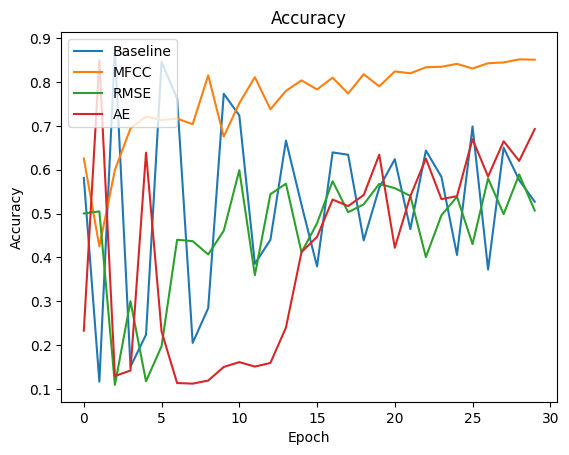

In [29]:
# generate a plot showing the development of accuracy over epochs

plt.plot(hist_baseline.history['accuracy'])
plt.plot(hist_lstm.history['accuracy'])
plt.plot(hist_rmse.history['accuracy'])
plt.plot(hist_ae.history['accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Baseline', 'MFCC', 'RMSE', 'AE'], loc = 'upper left')
plt.show()

In [28]:
# confusion matrices
# these are not identical to the ones in the report as they are based on the latest run of each model

print(matrix) # this is the mfcc confusion matrix
print(matrix_ae)
print(matrix_rmse)
print(matrix_baseline)

tf.Tensor(
[[1724  405]
 [  46  191]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1493  636]
 [  64  173]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[ 936 1193]
 [  60  177]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1908  221]
 [ 207   30]], shape=(2, 2), dtype=int32)
